In [1]:
%matplotlib ipympl

In [2]:
from collections import defaultdict
import os.path as op
from cycler import cycler
from glob import glob

import h5py
import numpy as np
import scipy
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from viz import (plot_learning, plot_state_traj, plot_all_units,
                 plot_weight_distr)
from train import solve_ls_batch
from utils import get_gaussian_targets, est_dimensionality

In [3]:
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)

In [4]:
# def logistic_func(x, gain, thresh, y_intercept, height):
def logistic_func(x, gain, thresh, y_intercept):
    '''Logistic curve defined by 4 parameters.'''
    height = 1 - y_intercept
    return height / (1 + np.exp(-gain * (x - thresh))) + y_intercept

def get_stable_timescale(mse_overtime, times):
    '''Calculate the timescale of stability and accuracy of fitted response.'''
    xdata = times.copy()
    # scipy opt requires better precision
    ydata = mse_overtime.astype(np.float64)
    # all parameters of logistic function should be positive in this case
    # bounds = ([0.0, 0.0, 0.0, 0.0], [np.inf, np.inf, np.inf, np.inf])
    bounds = ([0.0, 0.0, 0.0], [np.inf, np.inf, np.inf])
    popt, pcov = scipy.optimize.curve_fit(logistic_func, xdata, ydata, bounds=bounds)
    ydata_model = logistic_func(xdata, *popt)
    # gain_, thresh_, y_intercept_, height_ = popt
    gain_, thresh_, y_intercept_ = popt
    return thresh_, y_intercept_, ydata_model

def plot_mse_overtime(response_times, final_mse_overtime, ydata_model, timescale):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.plot(response_times, final_mse_overtime, c='0.6', label='data')
    ax.plot(response_times, ydata_model, c='k', lw=3, label='logistic fit')
    # ax.axhline(1.0, c='k', ls=':')
    ax.axvline(timescale, c='k', ls=':')
    ax.set_yticks([0.0, 1.0])
    ax.set_xticks([0, 0.5, 1])
    ax.set_ylabel('normalized MSE')
    ax.set_xlabel('time (s)')

    # ax2 = ax.twinx()
    # ax2.set_ylim([0, 10])
    # ax2.scatter(delay_times, dim_over_time, c='r')
    # ax2.set_ylabel('dimensionality')

    ax.legend()
    fig.tight_layout()
    return fig

In [ ]:
# get simulation data for a single random network
f_name = '/home/ryan/Dropbox/data/time_coding_output/2025_09_23_noise_sweep/sim_data_net02_c6e2d15_2025-09-23_11:51:02.hdf5'
with h5py.File(f_name, 'r') as f_read:
    print(f_read.keys())
    w_hz_init = f_read.get('W_hz')[:]
    offset_hz_init = f_read.get('offset_hz')[:]
    hidden_rates = f_read.get('h_sp')[:]
    sim_params = f_read.get('sim_params')[:]

# tau, include_stp, noise_tau, noise_std, include_corr_noise, p_rel_range
include_stp = sim_params[:, 1] == 1
# convert boolean->string labels
net_type = np.empty_like(include_stp, dtype='<U8')
net_type[include_stp == True] = 'STP'
net_type[include_stp == False] = 'no STP'
noise_tau = sim_params[:, 2]
noise_std = sim_params[:, 3]

<KeysViewHDF5 ['W_hz', 'ext_in', 'h_sp', 'offset_hz', 'r', 'sim_params', 'u']>


In [ ]:
# network/sim parameters
n_conditions, n_trials = hidden_rates.shape[:2]
n_outputs, n_hidden = w_hz_init.shape

# temporal parameters (see param_sweep.py)
dt = 1e-3  # 1 ms
tstop = 1.2  # 1 sec
times = np.arange(-0.1 + dt, tstop + dt, dt)
n_times = len(times)
perturb_dur = 0.05  # 50 ms
perturb_win_mask = np.logical_and(times > -perturb_dur, times < 0)

# target parameters (see param_sweep.py)
targ_std = 0.05 / np.sqrt(2)  # ~35 ms
# tile center of target delays spanning sim duration (minus margins)
delay_times = np.linspace(0.1, 1.0, n_outputs)
n_trials_train = n_trials - 1  # for leave-one-out training/testing
targets_train = get_gaussian_targets(n_trials_train, delay_times, times, targ_std)
targets_test = get_gaussian_targets(1, delay_times, times, targ_std)

# define loss functions
mse_overtime_fn = torch.nn.MSELoss(reduction='none')

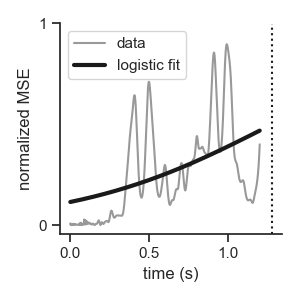

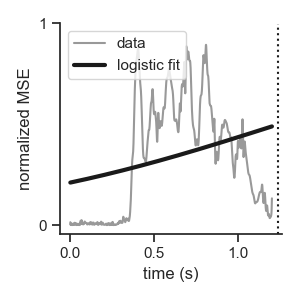

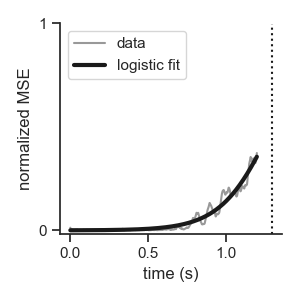

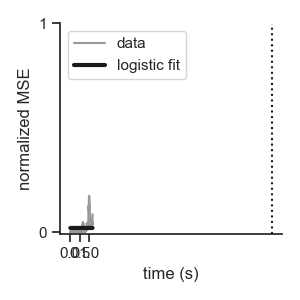

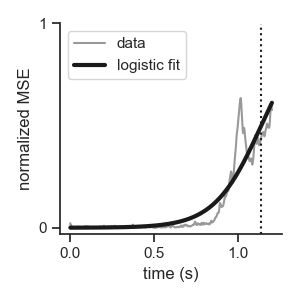

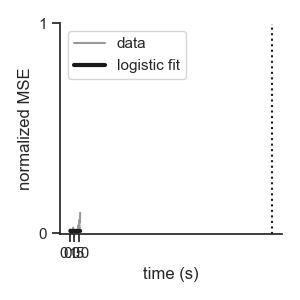

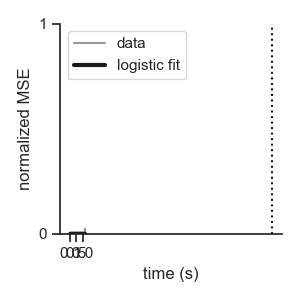

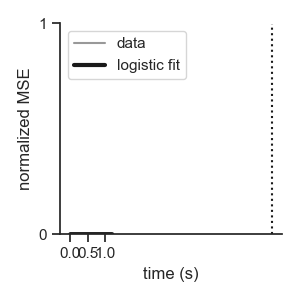

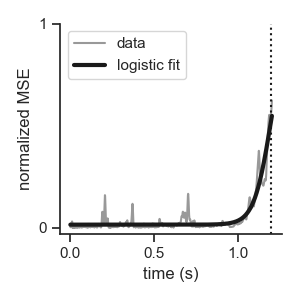

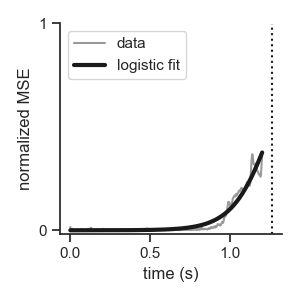

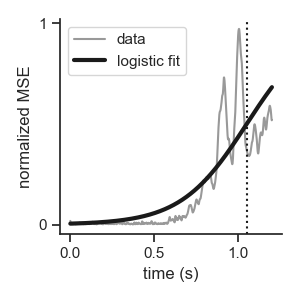

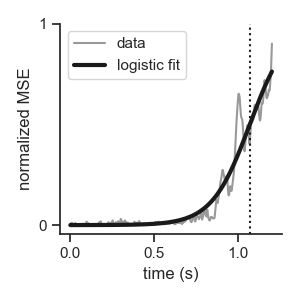

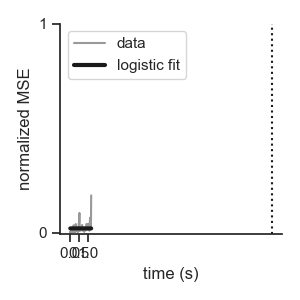

In [7]:
# calculate timescale and fitting accuracy for each network condition
timescales = list()
accuracies = list()

for cond_idx in range(n_conditions):
    # ...for storing results from each fold of leave-one-out training/testing
    final_losses = list()
    final_mses_overtime = list()
    init_losses = list()
    init_mses_overtime = list()

    # leave-one-out training/testing
    trial_idxs = np.arange(n_trials)
    for trial_idx in trial_idxs:
        # parse trials into two batches, one for testing, the rest for training
        train_mask = trial_idxs != trial_idx
        hidden_rates_train = torch.tensor(hidden_rates[cond_idx, train_mask, :, :])
        hidden_rates_test = torch.tensor(hidden_rates[cond_idx, trial_idx:trial_idx + 1, :, :])

        # solve for output weights and offsets via least squares regression
        w_hz_, offset_hz_ = solve_ls_batch(hidden_rates_train[:, ~perturb_win_mask, :],
                                        targets_train[:, ~perturb_win_mask, :])

        # compute output and loss with **fitted** parameters
        output_batch_test = hidden_rates_test @ w_hz_.T + offset_hz_
        mse = mse_overtime_fn(output_batch_test[:, times > 0, :], targets_test[:, times > 0, :])
        mse = mse.mean(dim=(0, 2)) / (targets_test[:, times > 0, :] ** 2).mean()  # normalize
        final_mses_overtime.append(mse)
        final_losses.append(mse.mean())  # grand total MSE

        # compute output and loss with **initial** parameters
        output_batch_test = hidden_rates_test @ w_hz_init.T + offset_hz_init
        mse = mse_overtime_fn(output_batch_test[:, times > 0, :], targets_test[:, times > 0, :])
        mse = mse.mean(dim=(0, 2)) / (targets_test[:, times > 0, :] ** 2).mean()  # normalize
        init_mses_overtime.append(mse)
        init_losses.append(mse.mean())  # grand total MSE

    final_loss = np.mean(final_losses)
    final_mse_overtime = np.mean(final_mses_overtime, axis=0)
    init_loss = np.mean(init_losses)
    init_mse_overtime = np.mean(init_mses_overtime, axis=0)

    timescale, accuracy, ydata_model = get_stable_timescale(final_mse_overtime,
                                                            times[times > 0])
    timescales.append(timescale)
    # use final total loss instead of y-intercept of logistic function
    accuracies.append(final_loss)

    if timescale > 1 or timescale < 0:
        print(f'Warning: timescale estimated to be {timescale}')
        fig = plot_mse_overtime(times[times > 0], final_mse_overtime, ydata_model, timescale)
        # fig.show()

In [8]:
# plot results
data = {'timescale': timescales, 'accuracy': accuracies, 'net_type': net_type,
        'noise_tau': noise_tau, 'noise_std': noise_std}
df = pd.DataFrame(data)

In [9]:
df_stp = df[df['net_type'] == 'STP']
df_stp_timescales = df_stp.pivot(index='noise_tau', columns='noise_std', values='timescale')
df_stp_timescales.sort_values(by='noise_tau', ascending=False, inplace=True)

df_no_stp = df[df['net_type'] == 'no STP']
df_no_stp_timescales = df_no_stp.pivot(index='noise_tau', columns='noise_std', values='timescale')
df_no_stp_timescales.sort_values(by='noise_tau', ascending=False, inplace=True)

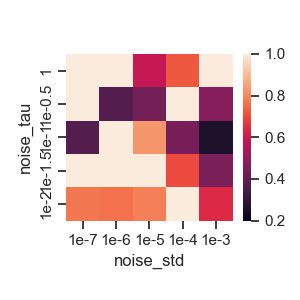

In [10]:
xticklabels = ['1e-7', '1e-6', '1e-5', '1e-4', '1e-3']
yticklabels = ['1', '1e-0.5', '1e-1', '1e-1.5', '1e-2']

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.heatmap(df_no_stp_timescales, vmin=0.2, vmax=1.0, square=True,
            ax=ax, cbar_kws={'shrink': 0.7},
            xticklabels=xticklabels, yticklabels=yticklabels)
fig.tight_layout()

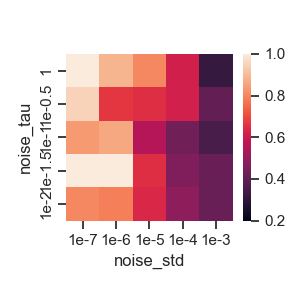

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.heatmap(df_stp_timescales, vmin=0.2, vmax=1.0, square=True,
            ax=ax, cbar_kws={'shrink': 0.7},
            xticklabels=xticklabels, yticklabels=yticklabels)
fig.tight_layout()

In [63]:
df_diff = df_stp_timescales - df_no_stp_timescales
df_diff.mean(axis=None)

-0.10735677755971584

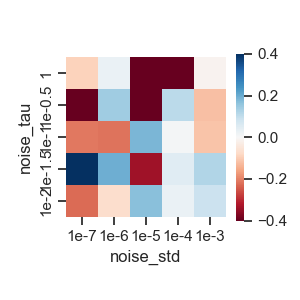

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.heatmap(df_diff, vmin=-0.4, vmax=0.4, square=True, cmap='RdBu', ax=ax,
            cbar_kws={'shrink': 0.7},
            xticklabels=xticklabels, yticklabels=yticklabels)
fig.tight_layout()

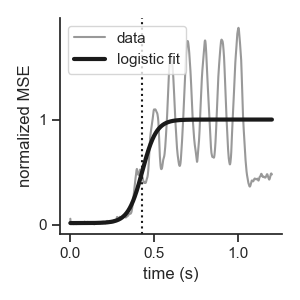

In [59]:
response_times = times[times > 0]
timescale, accuracy, ydata_model = get_stable_timescale(final_mse_overtime,
                                                        response_times)

fig = plot_mse_overtime(response_times, final_mse_overtime, ydata_model, timescale)

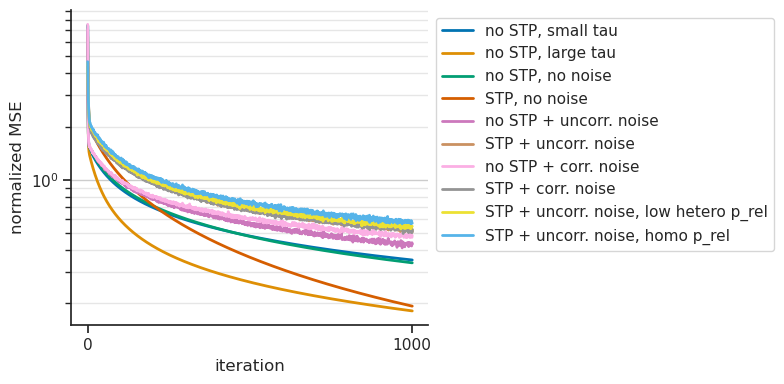

In [ ]:
# plot avg learning curve across conditions on one set of axes
cm_hidden = sns.color_palette('colorblind')
fig_learning, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.set_prop_cycle(cycler('color', cm_hidden))

losses_avg = np.mean(loss_curve, axis=0)
trial_idxs = np.arange(loss_curve.shape[2])
for c_idx, sim_type in enumerate(sim_type_labels):
    losses_sim_type = losses_avg[c_idx, :]
    axes.semilogy(trial_idxs, losses_sim_type, lw=2, label=sim_type)
axes.grid(axis='y')
axes.grid(which="minor", color="0.9")
ub_xtick = trial_idxs[-1]
axes.set_xticks([0, ub_xtick])
axes.set_xlabel('iteration')
axes.set_ylabel('normalized MSE')
axes.legend(ncols=1, loc='upper left', bbox_to_anchor=(1, 1))
fig_learning.tight_layout()
fname = 'learning.png'
fig_learning.savefig(op.join('/home/ryan/Desktop', fname))

/tmp/ipykernel_217653/1286987446.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


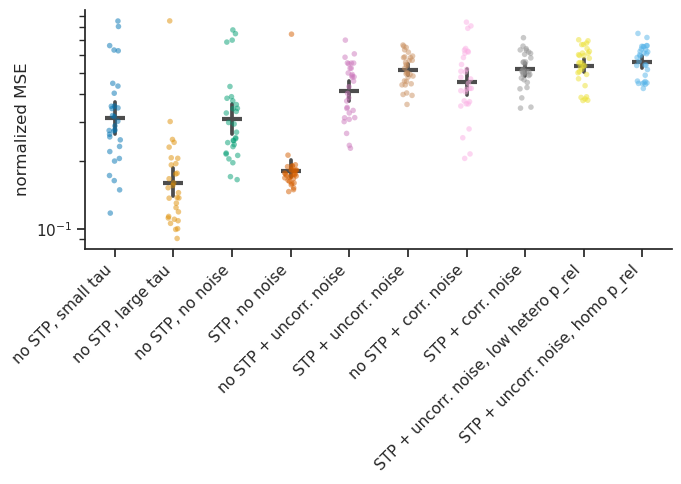

In [ ]:
data = {key: final_loss[:, idx] for idx, key in enumerate(sim_type_labels)}
df = pd.DataFrame(data)

fig_final_loss, axes = plt.subplots(figsize=(7, 5))
axes.set_yscale("log")
# sns.violinplot(df, palette='colorblind')
# sns.stripplot(df, size=4, color=".3")
sns.stripplot(df, size=4, palette='colorblind', alpha=0.5)
sns.pointplot(df, marker='_', markersize=15, markeredgewidth=3, color='0.3', linestyle='none')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
axes.set_ylabel('normalized MSE')
fig_final_loss.tight_layout()

fname = 'final_loss.png'
fig_final_loss.savefig(op.join('/home/ryan/Desktop', fname))

/tmp/ipykernel_217653/1961305855.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


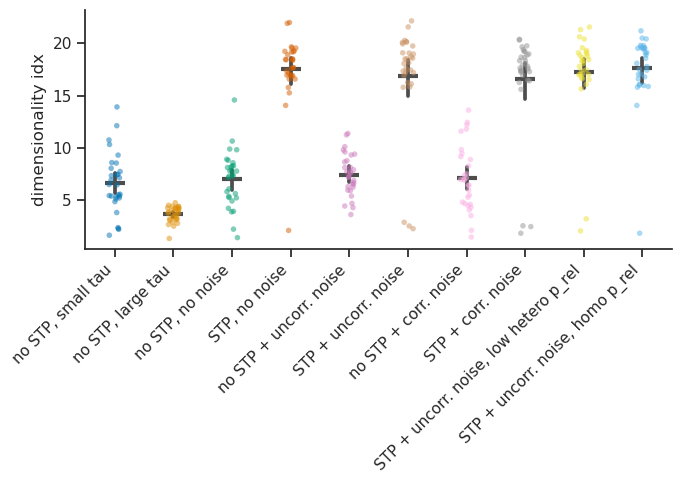

In [ ]:
data_dim = {key: dimensionality[:, idx] for idx, key in enumerate(sim_type_labels)}
df_dim = pd.DataFrame(data_dim)

fig_dimensionality, axes = plt.subplots(figsize=(7, 5))
# sns.boxplot(df_dim, fliersize=0, palette='colorblind')
# sns.stripplot(df_dim, size=4, color=".3")

sns.stripplot(df_dim, size=4, palette='colorblind', alpha=0.5)
sns.pointplot(df_dim, marker='_', markersize=15, markeredgewidth=3, color='0.3', linestyle='none')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
axes.set_ylabel('dimensionality idx')
fig_dimensionality.tight_layout()

fname = 'dimensionality.png'
fig_dimensionality.savefig(op.join('/home/ryan/Desktop', fname))